<a href="https://colab.research.google.com/github/oddgai/tensorflow_tutorial/blob/main/notebooks/cat_or_dog_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 犬猫画像分類 ver2
転移学習で犬猫分類モデルを強くする

https://www.tensorflow.org/tutorials/images/transfer_learning?hl=ja

In [ ]:
!pip3 uninstall tensorflow
!pip3 install tensorflow==2.4.0

Found existing installation: tensorflow 2.5.0
Uninstalling tensorflow-2.5.0:


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from tensorflow.keras.preprocessing import image_dataset_from_directory

## データの前処理

In [ ]:
# データをダウンロード
_URL = "https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip"
path_to_zip = tf.keras.utils.get_file("cats_and_dogs.zip", origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), "cats_and_dogs_filtered")

train_dir = os.path.join(PATH, "train")
validation_dir = os.path.join(PATH, "validation")

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = image_dataset_from_directory(train_dir, shuffle=True, batch_size=BATCH_SIZE, image_size=IMG_SIZE)
validation_dataset = image_dataset_from_directory(validation_dir, shuffle=True, batch_size=BATCH_SIZE, image_size=IMG_SIZE)

68608000/68606236 [==============================] - 1s 0us/step
Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


a


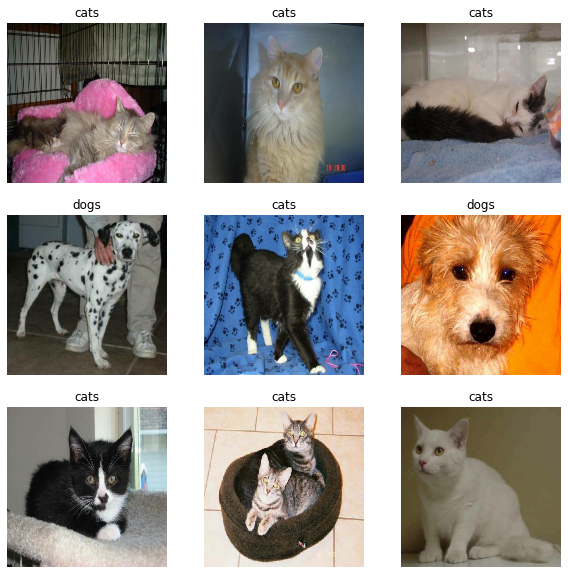

In [ ]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    print("a")
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [ ]:
# 検証用データの最初20%をテストデータに移す
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)
tf.data.experimental.cardinality(validation_dataset).numpy(), tf.data.experimental.cardinality(test_dataset).numpy()

(26, 6)

In [ ]:
# 効率よくデータセットを読み込めるようにする設定
AUTOTUNE = tf.data.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [ ]:
# データをかさ増し
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),  # 水平反転
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),  # 回転
])

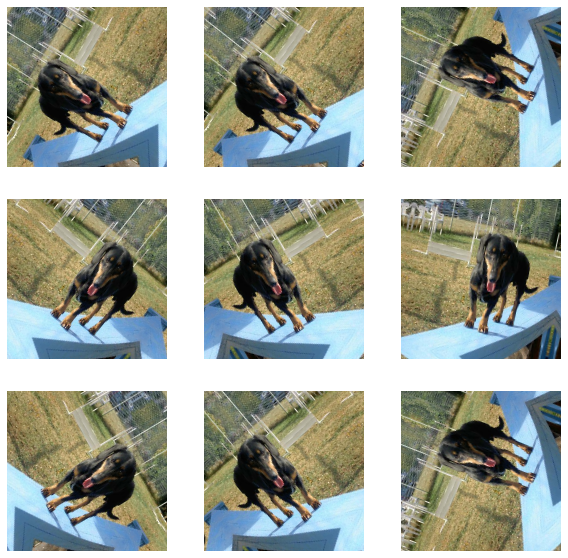

In [ ]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(first_image[None, ...])
    plt.imshow(augmented_image[0] / 255)
    plt.axis("off")

## 転移学習
* `tf.keras.applications.MobileNetV2`を使う
* `160x160x3`の画像を`5x5x1280`の特徴ブロックに変換するものらしい

In [ ]:
# モデルをパクる
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights="imagenet")

9412608/9406464 [==============================] - 0s 0us/step


In [ ]:
# モデルの出力形式をみる
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(image_batch.shape)
print(feature_batch.shape)

(32, 160, 160, 3)
(32, 5, 5, 1280)


In [ ]:
# モデルをフリーズさせる（パラメータが更新されないようにする）
base_model.trainable = False
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 80, 80, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [ ]:
### 各層を定義
# 前処理方法を転移学習に使うモデルからパクる
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

# 5x5x1280 -> 1x1280 にする（平均値をとる）
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

# 出力層
prediction_layer = tf.keras.layers.Dense(1)

In [ ]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)  # かさ増し
x = preprocess_input(x)  # 前処理
x = base_model(x, training=False)  # 転移学習に使うモデル
x = global_average_layer(x)  # 特徴量を一次元にする
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=["accuracy"])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

In [ ]:
# 学習前の精度
loss0, accuracy0 = model.evaluate(validation_dataset)

26/26 [==============================] - 3s 46ms/step - loss: 0.9197 - accuracy: 0.4984


In [ ]:
initial_epochs = 10
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
63/63 [==============================] - 8s 79ms/step - loss: 0.8102 - accuracy: 0.5345 - val_loss: 0.6005 - val_accuracy: 0.6399
Epoch 2/10
63/63 [==============================] - 5s 70ms/step - loss: 0.5840 - accuracy: 0.6595 - val_loss: 0.4337 - val_accuracy: 0.7661
Epoch 3/10
63/63 [==============================] - 5s 71ms/step - loss: 0.4587 - accuracy: 0.7505 - val_loss: 0.3338 - val_accuracy: 0.8342
Epoch 4/10
63/63 [==============================] - 5s 77ms/step - loss: 0.3832 - accuracy: 0.8180 - val_loss: 0.2649 - val_accuracy: 0.8849
Epoch 5/10
63/63 [==============================] - 5s 74ms/step - loss: 0.3381 - accuracy: 0.8370 - val_loss: 0.2203 - val_accuracy: 0.9183
Epoch 6/10
63/63 [==============================] - 5s 75ms/step - loss: 0.3004 - accuracy: 0.8630 - val_loss: 0.1932 - val_accuracy: 0.9282
Epoch 7/10
63/63 [==============================] - 5s 76ms/step - loss: 0.2751 - accuracy: 0.8750 - val_loss: 0.1752 - val_accuracy: 0.9394
Epoch 8/10
63

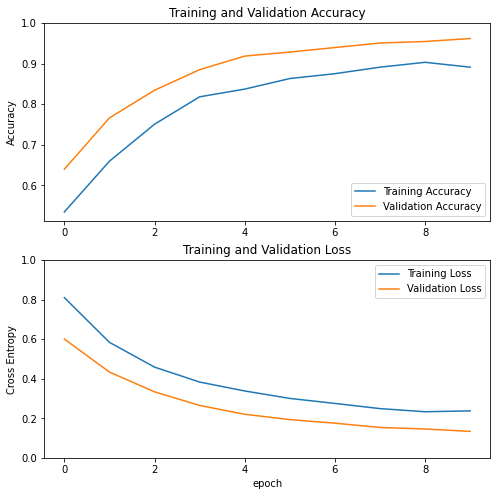

In [ ]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label="Training Accuracy")
plt.plot(val_acc, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.ylabel("Accuracy")
plt.ylim([min(plt.ylim()),1])
plt.title("Training and Validation Accuracy")

plt.subplot(2, 1, 2)
plt.plot(loss, label="Training Loss")
plt.plot(val_loss, label="Validation Loss")
plt.legend(loc="upper right")
plt.ylabel("Cross Entropy")
plt.ylim([0,1.0])
plt.title("Training and Validation Loss")
plt.xlabel("epoch")
plt.show()

## ファインチューニング
転移学習に使うモデルの最後のほうだけを今回の問題用に学習させる

In [ ]:
base_model.trainable = True

# 100層目から後ろを学習させる
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

In [ ]:
# ファインチューニングのときは、過学習を防ぐために学習率を小さめにするといいらしい
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              metrics=["accuracy"])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

In [ ]:
# ファインチューニング前の学習に追加して学習する
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20
63/63 [==============================] - 10s 89ms/step - loss: 0.1897 - accuracy: 0.9161 - val_loss: 0.0578 - val_accuracy: 0.9802
Epoch 11/20
63/63 [==============================] - 5s 76ms/step - loss: 0.1205 - accuracy: 0.9533 - val_loss: 0.0442 - val_accuracy: 0.9876
Epoch 12/20
63/63 [==============================] - 5s 77ms/step - loss: 0.1198 - accuracy: 0.9490 - val_loss: 0.0473 - val_accuracy: 0.9876
Epoch 13/20
63/63 [==============================] - 5s 77ms/step - loss: 0.1036 - accuracy: 0.9592 - val_loss: 0.0504 - val_accuracy: 0.9777
Epoch 14/20
63/63 [==============================] - 5s 78ms/step - loss: 0.0836 - accuracy: 0.9628 - val_loss: 0.0461 - val_accuracy: 0.9752
Epoch 15/20
63/63 [==============================] - 5s 82ms/step - loss: 0.0928 - accuracy: 0.9547 - val_loss: 0.0332 - val_accuracy: 0.9814
Epoch 16/20
63/63 [==============================] - 5s 82ms/step - loss: 0.0680 - accuracy: 0.9717 - val_loss: 0.0340 - val_accuracy: 0.9851
Epoch

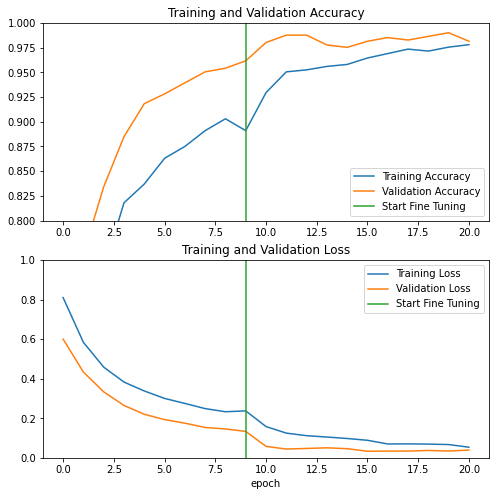

In [ ]:
acc += history_fine.history["accuracy"]
val_acc += history_fine.history["val_accuracy"]

loss += history_fine.history["loss"]
val_loss += history_fine.history["val_loss"]

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label="Training Accuracy")
plt.plot(val_acc, label="Validation Accuracy")
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label="Start Fine Tuning")
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")

plt.subplot(2, 1, 2)
plt.plot(loss, label="Training Loss")
plt.plot(val_loss, label="Validation Loss")
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label="Start Fine Tuning")
plt.legend(loc="upper right")
plt.title("Training and Validation Loss")
plt.xlabel("epoch")
plt.show()

In [ ]:
model.evaluate(test_dataset)

6/6 [==============================] - 1s 51ms/step - loss: 0.0512 - accuracy: 0.9792


[0.05121062323451042, 0.9791666865348816]

## 推論

In [ ]:
image_batch.shape

TensorShape([32, 160, 160, 3])

In [ ]:
pred = model.predict_on_batch(image_batch).flatten()

In [ ]:
pred

array([  7.2793508, -10.005977 , -10.17338  ,   6.8382144,   4.8218317,
       -10.176516 ,   6.996603 ,   5.3986683,  -7.065908 ,  -6.605328 ,
       -10.4524   ,   4.9692044,   7.9051356,   8.11351  ,  10.523213 ,
        -9.361899 , -11.310998 ,  -9.241892 ,   5.51722  ,  -9.472615 ,
        -9.399589 ,  -1.7918422,  -7.9168515, -11.272813 ,   6.365584 ,
        -8.329513 ,  -7.0145545, -10.149949 ,   4.521544 , -10.966251 ,
       -10.692867 ,   8.524358 ], dtype=float32)

In [ ]:
tf.nn.sigmoid(pred)

<tf.Tensor: shape=(32,), dtype=float32, numpy=
array([9.9931085e-01, 4.5127359e-05, 3.8171627e-05, 9.9892908e-01,
       9.9201232e-01, 3.8052123e-05, 9.9908590e-01, 9.9549782e-01,
       8.5299124e-04, 1.3513106e-03, 2.8878041e-05, 9.9309921e-01,
       9.9963129e-01, 9.9970067e-01, 9.9997306e-01, 8.5929329e-05,
       1.2237443e-05, 9.6884709e-05, 9.9599910e-01, 7.6924036e-05,
       8.2751263e-05, 1.4284700e-01, 3.6441546e-04, 1.2713761e-05,
       9.9828327e-01, 2.4123142e-04, 8.9789915e-04, 3.9076549e-05,
       9.8924470e-01, 1.7274682e-05, 2.2705803e-05, 9.9980146e-01],
      dtype=float32)>

Predictions:
 [0 1 1 0 0 1 1 0 0 1 1 1 1 0 0 0 1 1 0 0 0 1 1 0 1 0 0 0 1 1 0 0]
Labels:
 [0 1 1 0 0 1 1 0 0 1 1 1 1 0 1 0 1 1 0 0 0 1 1 0 1 0 0 0 1 1 0 0]


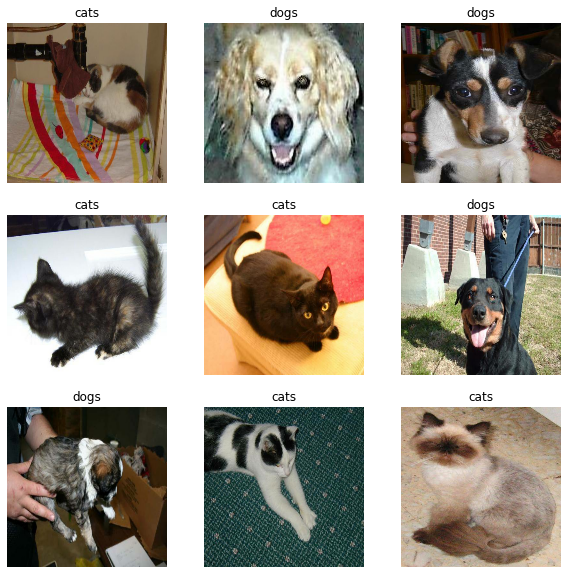

In [ ]:
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print("Predictions:\n", predictions.numpy())
print("Labels:\n", label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

In [ ]:
import h5py
h5py.__version__

'2.10.0'

In [ ]:
def sample_predict(img):
    pred = tf.nn.sigmoid(model.predict(img[None, ...]))
    if pred < 0.5:
        print(f"this is cat! ({pred})")
    else:
        print(f"this is dog! ({pred})")

this is cat! ([[0.00021555]])
this is dog! ([[0.99990845]])
this is dog! ([[0.999186]])
this is cat! ([[0.00026095]])
this is cat! ([[0.00010632]])
this is dog! ([[0.9998185]])
this is dog! ([[0.64084584]])
this is cat! ([[0.0154108]])
this is cat! ([[0.00102698]])


<Figure size 720x720 with 0 Axes>

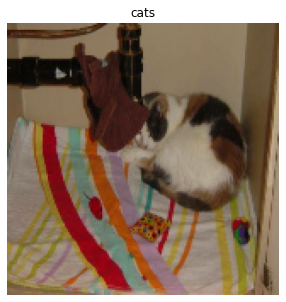

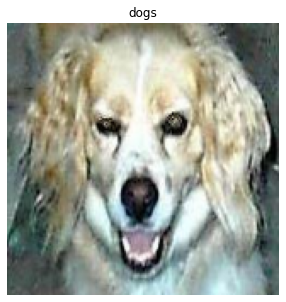

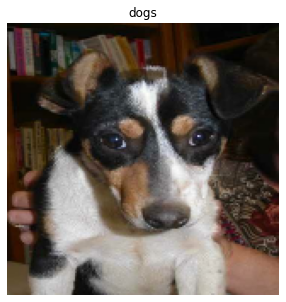

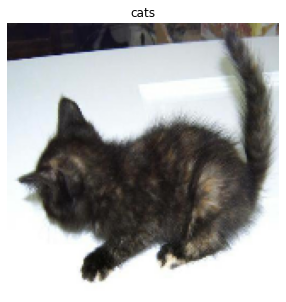

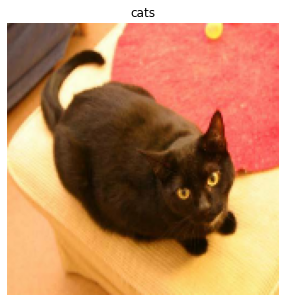

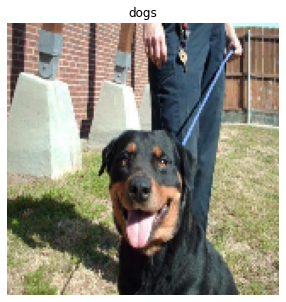

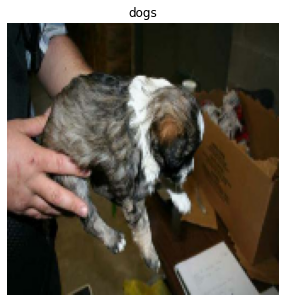

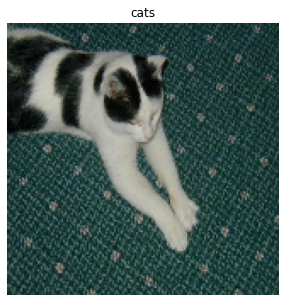

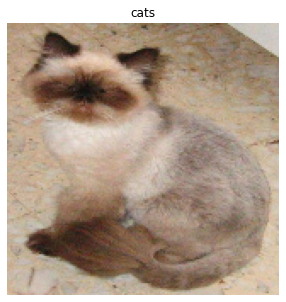

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.figure(figsize=(5,5))
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title(class_names[predictions[i]])
    plt.axis("off")
    sample_predict(image_batch[i])

モデルの保存

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
model.save("drive/My Drive/Colab Notebooks/cat_dog_model_2.4.0.h5")

In [ ]:
model_new = tf.keras.models.load_model("drive/My Drive/Colab Notebooks/cat_dog_model_2.4.0.h5")

In [ ]:
image_batch[0]

<tf.Tensor: shape=(160, 160, 3), dtype=float32, numpy=
array([[[  9.4625   ,  23.4625   ,   1.9812499],
        [ 20.721874 ,  34.351562 ,  11.684374 ],
        [  8.4921875,  21.257812 ,   6.6640625],
        ...,
        [  2.265625 ,   9.1171875,   9.3515625],
        [  3.259369 ,  16.296844 ,  15.037476 ],
        [  6.259384 ,  24.142204 ,  22.895332 ]],

       [[ 30.315624 ,  44.192184 ,  20.932812 ],
        [ 17.832813 ,  30.9625   ,  12.554687 ],
        [ 12.6328125,  22.875    ,  11.8671875],
        ...,
        [  2.265625 ,  10.296875 ,   3.8828125],
        [  1.       ,  14.129684 ,   5.3703156],
        [  1.       ,  14.123436 ,   5.753128 ]],

       [[ 19.221874 ,  31.721874 ,  15.845312 ],
        [ 27.110937 ,  39.240623 ,  25.592188 ],
        [ 20.03125  ,  31.796875 ,  21.734375 ],
        ...,
        [  5.9921875,  17.375    ,   3.7578125],
        [  1.6296844,  12.407791 ,   1.0187378],
        [  4.259384 ,  20.271896 ,   7.7718964]],

       ...,

     